In [1]:
# import sys
# !{sys.executable} -m pip install ing_theme_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# import qbstyles
# from ing_theme_matplotlib import mpl_style
import glacierml as gl
from tqdm import tqdm

# Step 1: Organize the data

## A. Load and organize the Glathida dataset

In [2]:
# raw_dataset = pd.read_csv('/data/fast0/datasets/glathida-3.1.0/data/T.csv')

TTT = pd.read_csv('/home/sa42/data/glac/T_models/TTT.csv')
glathida = TTT[[
#     'GlaThiDa_ID',
#     'POLITICAL_UNIT',
#     'GLACIER_NAME',
#     'SURVEY_DATE',
#     'PROFILE_ID',
#     'POINT_ID',
    'POINT_LAT',
    'POINT_LON',
    'ELEVATION',
    'THICKNESS',
#     'THICKNESS_UNCERTAINTY',
#     'DATA_FLAG',
#     'REMARKS'
]]
glathida = glathida.dropna()

/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (2,4,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### separate out features - what will be trained to predict desired attribute

In [3]:
train_dataset = glathida.sample(frac=0.8, random_state=0)
test_dataset = glathida.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop('THICKNESS')
test_labels = test_features.pop('THICKNESS')

train_features.describe().transpose()[['mean', 'std']]

,mean,std
POINT_LAT,47.477816,53.238428
POINT_LON,-46.458083,45.484560
ELEVATION,1175.033891,937.446613


# Step 2: Setup the Model

### Establish normalization layers

In [4]:
normalizer = {}
variable_list = list(train_features)
for variable_name in tqdm(variable_list):

    normalizer[variable_name] = gl.preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = gl.preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

  0%|          | 0/3 [00:00<?, ?it/s]2022-03-20 00:00:46.107558: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-20 00:00:46.107617: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-20 00:00:46.108540: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 3/3 [01:10<00:00, 23.49s/it]


In [5]:
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [6]:
%%time
for variable_name in tqdm(variable_list):

    linear_model[variable_name] = gl.build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=100,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

100%|██████████| 3/3 [2:36:43<00:00, 3134.56s/it]

CPU times: user 3h 19min, sys: 11min 12s, total: 3h 30min 13s
Wall time: 2h 36min 43s


In [7]:
# fig,ax=plt.subplots(2,6,figsize=(10,10))
# for i, variable_name in enumerate(variable_list):
# #     mpl_style("dark")
#     ax = plt.subplot(4,4,i+1)
#     plt.subplot(4,4,i+1)
#     gl.plot_loss(linear_history[variable_name])
#     ax.set_title(variable_name)
# #     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_loss.eps")

# Linear regression with multiple inputs

In [8]:
linear_model = gl.build_linear_model(normalizer['ALL'])

linear_history['MULTI'] = linear_model.fit(
train_features, train_labels,        
   epochs=100,
   verbose=0,
   validation_split = 0.2)

linear_results['MULTI'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

In [9]:
# gl.plot_loss(history_full)
# # plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

## Define regression functions

In [10]:
# test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [11]:
for variable_name in tqdm(variable_list):

    dnn_model[variable_name] = gl.build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=100,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

100%|██████████| 3/3 [5:11:10<00:00, 6223.34s/it]  


In [12]:
# fig,ax=plt.subplots(4,4,figsize=(10,10))
# for i, variable_name in enumerate(variable_list):
#     plt.subplot(4,4,i+1)
#     xmax = np.max(train_features[variable_name])
#     xmin = np.min(train_features[variable_name])
#     x = tf.linspace(xmin, xmax, 101)
#     y = dnn_model[variable_name].predict(x)
#     plot_single_model_variable(x,y,variable_name)

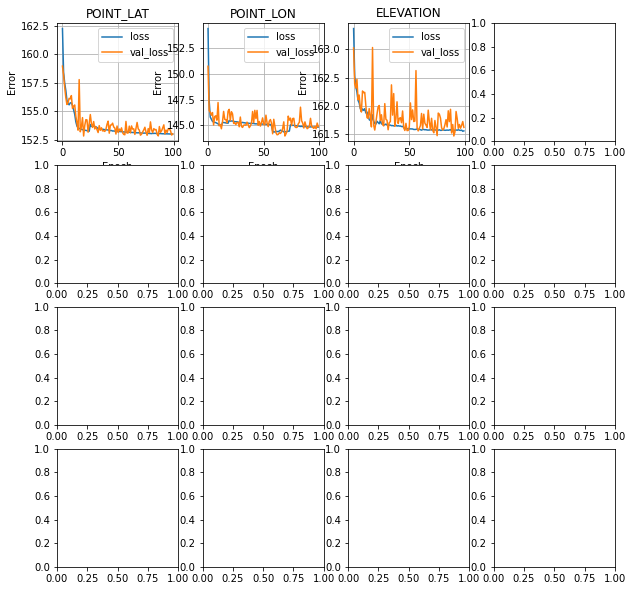

In [13]:
fig,ax=plt.subplots(4,4,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(4,4,i+1)
    gl.plot_loss(dnn_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")

# Full model

In [14]:
dnn_full_model = gl.build_dnn_model(normalizer['ALL'])

In [15]:
%%time
dnn_history['MULTI'] = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

dnn_results['MULTI'] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

CPU times: user 14h 26min 51s, sys: 3h 29min, total: 17h 55min 52s
Wall time: 1h 44min 55s


<function glacierml.plot_loss(history)>

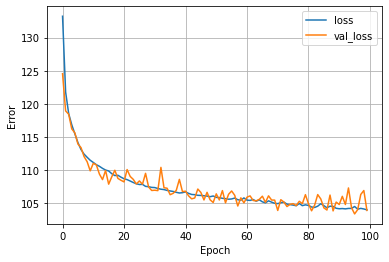

In [16]:
gl.plot_loss(dnn_history['MULTI'])
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

(0.0, 200.0)

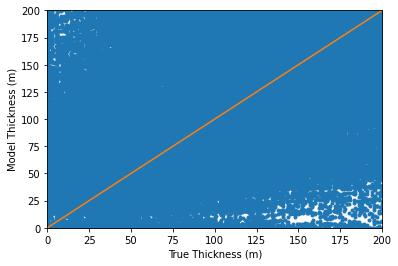

In [17]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,200),(0,200),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,200))
plt.ylim((0,200))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")

# Collect Results

In [18]:
dfs = pd.DataFrame()
for variable_name in list(dnn_history):    
    df1 = pd.DataFrame(dnn_history[variable_name].history)
    df2 = pd.DataFrame(linear_history[variable_name].history)
    df1 = df1.loc[[df1.last_valid_index()]]
    df2 = df2.loc[[df2.last_valid_index()]]
    df1['Architecture'] = 'DNN'
    df2['Architecture'] = 'Linear'
    df1.insert(0, 'Variable', [variable_name])
    df2.insert(0, 'Variable', [variable_name])
    df = pd.concat([df1,df2])
    dfs = dfs.append(df)
df = dfs[[
    'Architecture',
    'Variable',
    'loss',
    'val_loss'
]]
df = df.sort_values(by=['Architecture','Variable'], ascending=[False,False])
print(df.to_latex(index=False))

\begin{tabular}{llrr}
\toprule
Architecture &  Variable &       loss &   val\_loss \\
\midrule
      Linear & POINT\_LON & 166.476715 & 166.766388 \\
      Linear & POINT\_LAT & 184.572067 & 184.880463 \\
      Linear &     MULTI & 162.604507 & 162.882751 \\
      Linear & ELEVATION & 175.159943 & 175.364639 \\
         DNN & POINT\_LON & 144.830627 & 144.870621 \\
         DNN & POINT\_LAT & 153.009506 & 153.039169 \\
         DNN &     MULTI & 104.044724 & 103.954994 \\
         DNN & ELEVATION & 161.558121 & 161.620071 \\
\bottomrule
\end{tabular}

